In [2]:
import numpy as np
import xarray as xr

import datetime as dt
import os
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
import re
from scipy.signal import welch, csd
from scipy.stats import chi2
from process_fast_data.fast_data_calculate_spectra_nomrd import calculate_mrd_for_df, fast_data_files_to_dataframe
from sublimpy import extrautils

In [3]:
# DATA_DIR = "/storage/elilouis/sublimationofsnow/"
DATA_DIR = "/Users/elischwat/Development/data/sublimationofsnow/"

DATES = pd.Series(['20230418', '20230419'])
DATE_LOCAL = '20230418'

# DATES = pd.Series(['20230409', '20230410'])
# DATE_LOCAL = '20230409'

# TOOLS

## SAIL Data

In [4]:
class FastData(object):
    data = None

class FastDataSAIL(FastData):
    @staticmethod
    def open_raw(files):
        files = sorted(files)
        high_rate_dfs = []
        for file in files:
            # Regular expression. extract date
            date = re.search(r"gucecorM1\.00\.(\d+)\.", file).group(1)
            df = pd.read_csv(file, skiprows=1, header=None).rename(
                    columns = dict(
                        zip(range(0,10), 
                        [
                            'Timestamp',
                            'u',
                            'v',
                            'w',
                            'windspeed units (M = m/s)',
                            'Speed of Sound',
                            'Status (00 means okay)',
                            'CO2 analog voltage output',
                            'H20 analog voltage output',
                            'Checksum',
                        ])
                    )
                )
            df['time'] = pd.to_datetime(
                f'{date} ' + df['Timestamp'].str[:-3],
                format="%Y%m%d %H:%M:%S.%f"
            )
            high_rate_dfs.append(df)
        return pd.concat(high_rate_dfs).set_index('time')
    
    @staticmethod
    def double_rotation(df, u_col, v_col, w_col):
        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

        # SECOND ROTATION
        mean_u = df[u_col].mean()
        mean_w = df[w_col].mean()
        phi = np.arctan2(mean_w, mean_u)
        adj_u = df[u_col]*np.cos(phi) + df[w_col]*np.sin(phi)
        adj_w = - df[u_col]*np.sin(phi) + df[w_col]*np.cos(phi)
        df[u_col] = adj_u
        df[w_col] = adj_w
        print(
            'Means after 2nd rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )
        return df
    
    def apply_direction_rotation(df, u_col, v_col, w_col, bearing):
        # + Ugeo represents wind blowing to the East (confusingly known as a "westerly"). 
        # + Vgeo is wind to the North (a "southerly" ). This is right handed with respect to an upward +Wgeo.


        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

# SAIL EC data

Open and wrangle the raw SAIL EC data

In [5]:
fast_data_files = DATES.apply(
    lambda date: glob.glob(
            os.path.join(
                DATA_DIR, 
                f"sail_fast_ecor_data/gucecorM1.00.{date}.000000.raw/**_sonic.raw"
            )
        )
).explode()
fast_data_files

0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
                           ...                        
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
Length: 96, dtype: object

In [6]:
fast_df_sail = FastDataSAIL.open_raw(fast_data_files)
fast_df_sail = utils.modify_df_timezone(fast_df_sail.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_sail = fast_df_sail.loc[DATE_LOCAL]
fast_df_sail = fast_df_sail.sort_index()

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

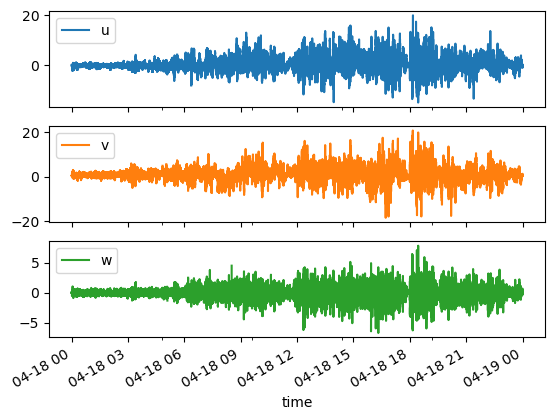

In [7]:
fast_df_sail[['u','v','w']].plot(subplots=True)

Calculate 30-minute mean u, v, w, and 30-min wind direction, plot it

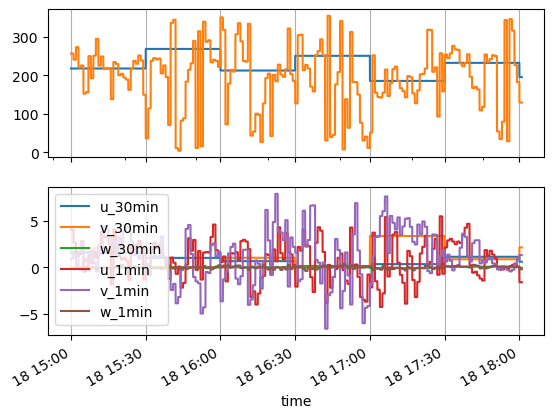

In [8]:
fast_df_sail = fast_df_sail.join(
    fast_df_sail.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sail = fast_df_sail.join(
    fast_df_sail.groupby(pd.Grouper(freq='1min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_1min',
        'v': 'v_1min',
        'w': 'w_1min',
    })
)
fast_df_sail['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sail['u_30min'], -fast_df_sail['v_30min']))
fast_df_sail['dir_30min'] = fast_df_sail['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

fast_df_sail['dir_1min'] = np.rad2deg(np.arctan2(-fast_df_sail['u_1min'], -fast_df_sail['v_1min']))
fast_df_sail['dir_1min'] = fast_df_sail['dir_1min'].apply(lambda dir: dir if dir >= 0 else dir+360)

fig, axes = plt.subplots(2,1)
fast_df_sail['dir_30min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_sail['dir_1min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_sail[['u_30min','v_30min','w_30min']].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[1])
fast_df_sail[['u_1min','v_1min','w_1min']].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [9]:
fast_df_sail = fast_df_sail.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 0.6618016000970252 1.1533358748732916e-16 0.04622414519004238
Means after 2nd rotation: 0.6634139201807067 1.1533358748732916e-16 -1.7559411395180424e-17
Means after 1st rotation: 0.9078757601427564 6.947449507584782e-17 0.07116325466865576
Means after 2nd rotation: 0.9106605320698945 6.947449507584782e-17 -5.746971100024176e-18
Means after 1st rotation: 0.35064010057550277 -6.000255329161135e-18 0.05577285762037964
Means after 2nd rotation: 0.35504801334290265 -6.000255329161135e-18 1.9157065191540498e-17
Means after 1st rotation: 2.278287499191075 1.6516584890547308e-16 -0.0662818459491865
Means after 2nd rotation: 2.279251458719014 1.6516584890547308e-16 -9.949749934064644e-18
Means after 1st rotation: 1.6761005345894482 -2.3911837285671085e-17 -0.046084167353162855
Means after 2nd rotation: 1.6767339540104949 -2.3911837285671085e-17 9.963265535696286e-19
Means after 1st rotation: 1.4498843014421823 1.3490925910749524e-16 -0.027700846955491278
Means after 2

In [10]:
fast_df_sail.index = fast_df_sail.index.get_level_values(1)

In [11]:
fast_df_sail['u'] = fast_df_sail['u'].interpolate()
fast_df_sail['v'] = fast_df_sail['v'].interpolate()
fast_df_sail['w'] = fast_df_sail['w'].interpolate()

Calculate MRD

In [ ]:
mrd_uw_sail = fast_df_sail.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 114022. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 114022, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 47.13it/s]


Got data of length 114232. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 114232, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 19032.58it/s]


Got data of length 113672. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 113672, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 20217.57it/s]


Got data of length 114134. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 114134, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 19463.13it/s]


Got data of length 113541. using M = 16
Timestep of fast data is: 0.0 ms
Dataset of length 113541, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 14126.20it/s]


Got data of length 113643. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 113643, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 16690.98it/s]


Got data of length 113951. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 113951, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 22615.88it/s]


Got data of length 114204. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 114204, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 24001.74it/s]


In [ ]:
mrd_uw_sail.hour_group = mrd_uw_sail.hour_group.str.replace('2023-04-18 ', '')

In [ ]:
daily_mrd_sail_chart = alt.Chart(
    mrd_uw_sail.reset_index().query("tau > 0")
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='sail')
daily_mrd_sail_chart

alt.Chart(...)

In [ ]:
mrd_uw_sail['time range'] = mrd_uw_sail.start_time.astype(str) + ' - ' + mrd_uw_sail.end_time.astype(str)

In [ ]:
alt.Chart(mrd_uw_sail.reset_index().query("tau > 0")).mark_line(strokeWidth=1).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Color('hour_group:O').scale(scheme='rainbow'),
    detail = 'time range'
).properties(width=300, height=300)

alt.Chart(...)

# SPLASH EC data

In [13]:
splash_files = np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.*.nc")
    ) if d in f]
    for d in DATES
]).flatten()
fast_df_splash = xr.open_mfdataset(splash_files).to_dataframe().rename(columns={
    'metek_u': 'u',
    'metek_v': 'v',
    'metek_w': 'w',
})

In [14]:
fast_df_splash = utils.modify_df_timezone(fast_df_splash.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_splash = fast_df_splash.loc[DATE_LOCAL]

In [15]:
fast_df_splash = fast_df_splash.join(
    fast_df_splash.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_splash['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_splash['u_30min'], -fast_df_splash['v_30min']))
fast_df_splash['dir_30min'] = fast_df_splash['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

fast_df_splash = fast_df_splash.join(
    fast_df_splash.groupby(pd.Grouper(freq='1min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_1min',
        'v': 'v_1min',
        'w': 'w_1min',
    })
)
fast_df_splash['dir_1min'] = np.rad2deg(np.arctan2(-fast_df_splash['u_1min'], -fast_df_splash['v_1min']))
fast_df_splash['dir_1min'] = fast_df_splash['dir_1min'].apply(lambda dir: dir if dir >= 0 else dir+360)

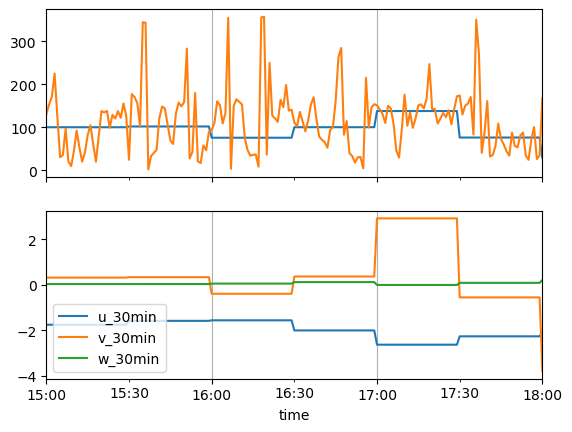

In [16]:
fast_df_splash_30min = fast_df_splash.groupby(pd.Grouper(freq='1min')).mean()
fig, axes = plt.subplots(2,1)
fast_df_splash_30min['dir_30min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_splash_30min['dir_1min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_splash_30min[['u_30min','v_30min','w_30min']].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [17]:
fast_df_splash = fast_df_splash.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 1.2666482748900492 -1.098831888759114e-16 0.0772666142960887
Means after 2nd rotation: 1.2690027509689321 -1.098831888759114e-16 4.226276495227362e-18
Means after 1st rotation: 1.0324662924246089 -1.266705712775666e-17 0.11195183171403797
Means after 2nd rotation: 1.0385181065427538 -1.266705712775666e-17 -4.486249399413817e-18
Means after 1st rotation: 1.428171009464732 2.957019466981188e-17 0.09460395440404679
Means after 2nd rotation: 1.431300925893781 2.957019466981188e-17 -3.3530488598804544e-17
Means after 1st rotation: 3.0867025680330658 -3.801882171832956e-16 -0.03322424124510729
Means after 2nd rotation: 3.0868813702033053 -3.801882171832956e-16 -5.5444115005897276e-18
Means after 1st rotation: 2.0051384174349507 -1.689725409703536e-16 0.04083325582150301
Means after 2nd rotation: 2.0055541448324257 -1.689725409703536e-16 2.125357741892729e-17
Means after 1st rotation: 2.0319159538937637 -1.6052391392183592e-16 0.05477563106018458
Means after 2nd rota

In [18]:
fast_df_splash.index = fast_df_splash.index.get_level_values(1)

In [19]:
fast_df_splash['u'] = fast_df_splash['u'].interpolate()
fast_df_splash['v'] = fast_df_splash['v'].interpolate()
fast_df_splash['w'] = fast_df_splash['w'].interpolate()

Calculate MRD

In [ ]:
mrd_uw_splash = fast_df_splash.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 6486.04it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 14704.57it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 16152.65it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 13923.55it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 21519.76it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 16329.33it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 22538.48it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 17630.18it/s]


In [ ]:
mrd_uw_splash.hour_group = mrd_uw_splash.hour_group.str.replace('2023-04-18 ', '')

In [ ]:
alt.Chart(mrd_uw_splash.reset_index()).mark_boxplot(size=10, outliers=False).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Column('hour_group'),
).properties(width=200, height=200)

alt.Chart(...)

In [ ]:
mrd_uw_splash.hour_group.unique()

array(['2023-04-09 00:00:00 - 2023-04-09 02:59:59.900000',
       '2023-04-09 03:00:00 - 2023-04-09 05:59:59.900000',
       '2023-04-09 06:00:00 - 2023-04-09 08:59:59.900000',
       '2023-04-09 09:00:00 - 2023-04-09 11:59:59.900000',
       '2023-04-09 12:00:00 - 2023-04-09 14:59:59.900000',
       '2023-04-09 15:00:00 - 2023-04-09 17:59:59.900000',
       '2023-04-09 18:00:00 - 2023-04-09 20:59:59.900000',
       '2023-04-09 21:00:00 - 2023-04-09 23:59:59.900000'], dtype=object)

In [ ]:
daily_mrd_splash_chart = alt.Chart(
    mrd_uw_splash.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='splash')
daily_mrd_splash_chart

alt.Chart(...)

# SOS EC data

Open data, average from 20hz to 10hz

In [20]:
sos_file_list = sorted(np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_**.nc")
    ) if d in f]
    for d in DATES
]).flatten())

fast_df_sos_all_data = fast_data_files_to_dataframe(
    sos_file_list,  #CORRECT THIS
    rotation='none'
)

In [21]:
fast_df_sos_all_data = utils.modify_df_timezone(fast_df_sos_all_data, 'UTC', 'US/Mountain')
fast_df_sos_all_data = fast_df_sos_all_data.set_index('time').loc[DATE_LOCAL]

In [22]:
fast_df_sos = fast_df_sos_all_data[['u_3m_c', 'v_3m_c', 'w_3m_c']].rename(columns={
    'u_3m_c': 'u',
    'v_3m_c': 'v',
    'w_3m_c': 'w',
})

In [23]:
fast_df_sos['dir'] = np.rad2deg(np.arctan2(-fast_df_sos['u'], -fast_df_sos['v']))

# Create 30min avgs
fast_df_sos = fast_df_sos.join(
    fast_df_sos.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sos['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sos['u_30min'], -fast_df_sos['v_30min']))
fast_df_sos['dir_30min'] = fast_df_sos['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

# Create 1min avgs
fast_df_sos = fast_df_sos.join(
    fast_df_sos.groupby(pd.Grouper(freq='1min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_1min',
        'v': 'v_1min',
        'w': 'w_1min',
    })
)
fast_df_sos['dir_1min'] = np.rad2deg(np.arctan2(-fast_df_sos['u_1min'], -fast_df_sos['v_1min']))
fast_df_sos['dir_1min'] = fast_df_sos['dir_1min'].apply(lambda dir: dir if dir >= 0 else dir+360)

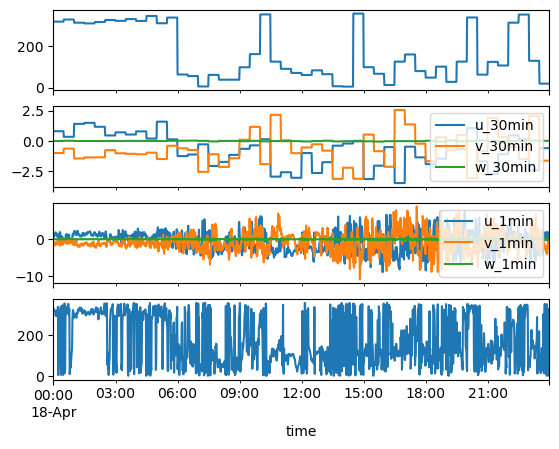

In [24]:
fast_df_sos_1min = fast_df_sos.groupby(pd.Grouper(freq='1min')).mean()
fig, axes = plt.subplots(4,1)
fast_df_sos_1min['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_sos_1min[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
fast_df_sos_1min[['u_1min','v_1min','w_1min']].plot(ax=axes[2])
fast_df_sos_1min['dir_1min'].plot(ax=axes[3], sharex=True)
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply rotation into a given wind direction

In [42]:
# import numpy as np

# def project_winds(u, v):
#     # Convert -45 degrees to radians
#     angle = np.radians(-45)
#     print(angle)
#     # Define the rotation matrix
#     rotation_matrix = np.array([
#         [np.cos(angle), -np.sin(angle)],
#         [np.sin(angle), np.cos(angle)]
#     ])
#     print(rotation_matrix)
#     # Original wind vector
#     wind_vector = np.array([u, v])
#     print(wind_vector)
#     # Projected wind vector
#     projected_vector = rotation_matrix @ wind_vector
#     print(projected_vector)
#     return projected_vector

# # Example usage
# u = 10  # Westerly wind component
# v = 5   # Southerly wind component
# projected = project_winds(u, v)
# print("Projected winds:", projected)

In [43]:
# src = fast_df_sos.loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1501']
# u, v = project_winds(
#     src['u'],
#     src['v']
# )
# src['u_proj'] = u 
# src['v_proj'] = v
# src['dir_proj'] = np.rad2deg(np.arctan2(-src['u_proj'], -src['v_proj']))

In [44]:
# src[['u', 'v', 'dir']].plot(subplots=True)

In [45]:
# src[['u_proj', 'v_proj', 'dir_proj']].plot(subplots=True)

Apply double rotation to 3hr chunks

In [25]:
fast_df_sos = fast_df_sos.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 1.4472486 -3.051758e-08 0.0074909516
Means after 2nd rotation: 1.4472678 -3.051758e-08 1.165602e-09
Means after 1st rotation: 1.2023139 2.8257016e-08 0.008348804
Means after 2nd rotation: 1.202343 2.8257016e-08 1.2009232e-09
Means after 1st rotation: 1.9015547 -2.2605613e-08 0.011437975
Means after 2nd rotation: 1.9015889 -2.2605613e-08 -9.889956e-10
Means after 1st rotation: 1.5724633 1.3111256e-07 -0.0052673933
Means after 2nd rotation: 1.5724721 1.3111256e-07 -1.2892264e-09
Means after 1st rotation: 1.9473157 -8.251049e-08 -0.011317748
Means after 2nd rotation: 1.9473485 -8.251049e-08 5.651403e-10
Means after 1st rotation: 1.8408698 -9.94647e-08 -0.018046634
Means after 2nd rotation: 1.8409578 -9.94647e-08 -4.803693e-09
Means after 1st rotation: 1.2515265 -1.808449e-07 0.009646556
Means after 2nd rotation: 1.2515633 -1.808449e-07 1.9515003e-09
Means after 1st rotation: 1.0377959 9.042245e-08 0.00890773
Means after 2nd rotation: 1.037834 9.042245e-08 1.62477

In [26]:
fast_df_sos.index = fast_df_sos.index.get_level_values(1)

In [27]:
fast_df_sos['u'] = fast_df_sos['u'].interpolate()
fast_df_sos['v'] = fast_df_sos['v'].interpolate()
fast_df_sos['w'] = fast_df_sos['w'].interpolate()

Calculate MRD

In [49]:
mrd_uu_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'u', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)
mrd_vv_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'v', 'v', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)
mrd_ww_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'w', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.00it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.13it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.08it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.22it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.06it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.05it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.07it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:28<00:00,  1.46it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.06it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.89it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.89it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [32:34<00:00, 46.55s/it]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.12it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.09it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [1:00:20<00:00, 86.20s/it]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.98it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.82it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.08it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.76it/s]


In [6]:
alt.Chart(
    mrd_uu_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='3m uu') | alt.Chart(
    mrd_vv_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='3m vv') | alt.Chart(
    mrd_ww_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='3m ww')

NameError: name 'mrd_uu_sos' is not defined

In [ ]:
mrd_uw_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.65it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.66it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.49it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.32it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.37it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:08<00:00,  5.19it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.80it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:08<00:00,  4.71it/s]


In [ ]:
mrd_uw_sos.hour_group = mrd_uw_sos.hour_group.str.replace('2023-04-09 ', '')

In [ ]:
daily_mrd_sos_chart = alt.Chart(
    mrd_uw_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q').scale(domain = [-0.1, 0.05]),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='sos')
daily_mrd_sos_chart

alt.Chart(...)

# Plot three sites comparison plot

In [ ]:
(
    daily_mrd_splash_chart & daily_mrd_sail_chart & daily_mrd_sos_chart
).resolve_scale(
    color='independent',
    x='shared',
    y='shared'
)

alt.VConcatChart(...)

# Calculate MRDs for April 18 1500-1800, at SOS, multiple heights

In [27]:
# fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800']
# fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 1800': f'{DATE_LOCAL} 2100']
fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 1200': f'{DATE_LOCAL} 1500']
# fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 0000': f'{DATE_LOCAL} 0300']

In [28]:
mrds_df_ls = []
for h in [3,5,10,15,20]:
    print(f"Processing height: {h}m")
    fast_df_sos_oneheight = fast_df_sos_1500_1800[[f'u_{h}m_c', f'v_{h}m_c', f'w_{h}m_c']].rename(columns={
        f'u_{h}m_c': 'u',
        f'v_{h}m_c': 'v',
        f'w_{h}m_c': 'w',
    })
    fast_df_sos_oneheight = FastDataSAIL.double_rotation(fast_df_sos_oneheight, 'u', 'v', 'w')
    fast_df_sos_oneheight['u'] = fast_df_sos_oneheight['u'].interpolate()
    fast_df_sos_oneheight['v'] = fast_df_sos_oneheight['v'].interpolate()
    fast_df_sos_oneheight['w'] = fast_df_sos_oneheight['w'].interpolate()
    mrds_df_ls.append(
        calculate_mrd_for_df(
            fast_df_sos_oneheight.reset_index(), 'u', 'w', shift=2000, parallelism=20
        ).assign(
            height = h
        )
    )

Processing height: 3m
Means after 1st rotation: 1.9489089 -1.7534963e-07 -0.010246838
Means after 2nd rotation: 1.9489357 -1.7534963e-07 -1.405045e-10
Got data of length 217200. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:07<00:00,  6.00it/s]


Processing height: 5m
Means after 1st rotation: 2.0392215 6.969023e-08 -0.019799529
Means after 2nd rotation: 2.0393178 6.969023e-08 9.273297e-09
Got data of length 217200. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:07<00:00,  6.05it/s]


Processing height: 10m
Means after 1st rotation: 1.8999861 -1.899621e-07 -0.07571541
Means after 2nd rotation: 1.9014943 -1.899621e-07 -1.278591e-08
Got data of length 217200. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:08<00:00,  4.88it/s]


Processing height: 15m
Means after 1st rotation: 1.853797 -1.3319827e-07 -0.11087868
Means after 2nd rotation: 1.8571101 -1.3319827e-07 1.8827603e-08
Got data of length 217200. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:07<00:00,  6.09it/s]


Processing height: 20m
Means after 1st rotation: 1.8875023 -3.4845115e-08 -0.16564526
Means after 2nd rotation: 1.894757 -3.4845115e-08 7.446739e-09
Got data of length 217200. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:08<00:00,  5.34it/s]


In [29]:
alt.Chart(
    pd.concat(mrds_df_ls).query("height > 2")
).mark_line(point=True).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('height:O'),
    tooltip = 'height:O',
)

alt.Chart(...)

## Rotate into pre-determined wind direction

In [ ]:
def double_rotation(df, u_col, v_col, w_col):
        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

        # SECOND ROTATION
        mean_u = df[u_col].mean()
        mean_w = df[w_col].mean()
        phi = np.arctan2(mean_w, mean_u)
        adj_u = df[u_col]*np.cos(phi) + df[w_col]*np.sin(phi)
        adj_w = - df[u_col]*np.sin(phi) + df[w_col]*np.cos(phi)
        df[u_col] = adj_u
        df[w_col] = adj_w
        print(
            'Means after 2nd rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )
        return df

In [ ]:
sos_file_list = sorted(np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_**.nc")
    ) if d in f]
    for d in DATES
]).flatten())

fast_df_sos_all_data = fast_data_files_to_dataframe(sos_file_list, rotation='none')
fast_df_sos_all_data = utils.modify_df_timezone(fast_df_sos_all_data, 'UTC', 'US/Mountain')
fast_df_sos_all_data = fast_df_sos_all_data.set_index('time').loc[DATE_LOCAL]
fast_df_sos = fast_df_sos_all_data[['u_3m_c', 'v_3m_c', 'w_3m_c']].rename(columns={
    'u_3m_c': 'u',
    'v_3m_c': 'v',
    'w_3m_c': 'w',
})

# Calculate integral length scales for all datasets

## For discreet periods

In [ ]:
def find_root(result, autocorr_col, time_col):
    # Assuming `data` is your DataFrame
    # Replace `data` with the actual DataFrame variable
    column_0 = result[autocorr_col]  # Extract column 0
    lag_s = result[time_col]     # Extract 'lag (s)' column

    # Find indices where column 0 changes sign
    sign_changes = np.where(np.diff(np.sign(column_0)))[0]

    if len(sign_changes) > 0:
        # Get the first root
        idx = sign_changes[0]
        print(f"The first root is at lag (s): {lag_s[idx]}")
        return idx
        # # Linear interpolation to find the root
        # x1, x2 = lag_s.iloc[idx], lag_s.iloc[idx + 1]
        # y1, y2 = column_0.iloc[idx], column_0.iloc[idx + 1]
        # root = x1 - y1 * (x2 - x1) / (y2 - y1)
        print(f"The first root is at lag (s): {root}")
    else:
        print("No root found in column 0.")

The first root is at lag (s): 249.9
The integration result_sail is: 79.25954937350747
The mean wind speed is: 0.8955566051258729
The integral length scale is: 70.98141296074485
The first root is at lag (s): 241.9
The integration result_splash is: 69.74542957420803
The mean wind speed is: 1.542315761062922
The integral length scale is: 107.56947529440508
The first root is at lag (s): 2088.5
The integration result_sos is: 423.61119289851985
The mean wind speed is: 1.600559949874878
The integral length scale is: 678.0151096720922


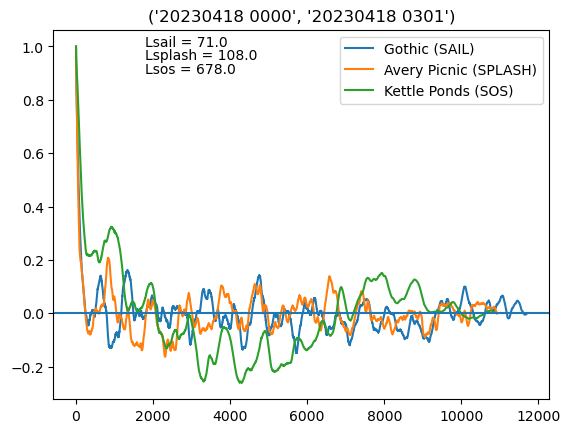

The first root is at lag (s): 757.3
The integration result_sail is: 160.30790320360217
The mean wind speed is: 1.874744723808671
The integral length scale is: 300.5363957157843
The first root is at lag (s): 585.0
The integration result_splash is: 111.24311417378225
The mean wind speed is: 2.078458640577893
The integral length scale is: 231.21421185929077
The first root is at lag (s): 1006.6
The integration result_sos is: 158.41345979864508
The mean wind speed is: 1.8072600364685059
The integral length scale is: 286.2943151328015


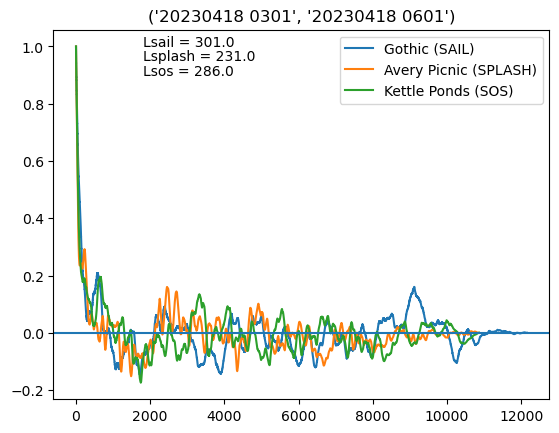

The first root is at lag (s): 148.3
The integration result_sail is: 36.1469825796002
The mean wind speed is: 2.4406782805377025
The integral length scale is: 88.2231552890049
The first root is at lag (s): 1351.1
The integration result_splash is: 174.49084406142714
The mean wind speed is: 2.919921407913005
The integral length scale is: 509.49955105977097
The first root is at lag (s): 544.15
The integration result_sos is: 72.4252091723043
The mean wind speed is: 3.426621675491333
The integral length scale is: 248.17379160181164


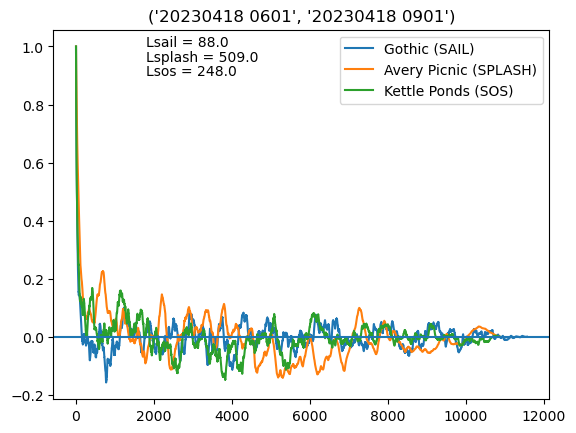

The first root is at lag (s): 902.6
The integration result_sail is: 183.13375880686215
The mean wind speed is: 3.334347006488048
The integral length scale is: 610.631500464565
The first root is at lag (s): 842.6
The integration result_splash is: 119.23606939152207
The mean wind speed is: 3.7739796099007257
The integral length scale is: 449.9944946483123
The first root is at lag (s): 336.85
The integration result_sos is: 66.67174135448367
The mean wind speed is: 3.7874984741210938
The integral length scale is: 252.51911864710314


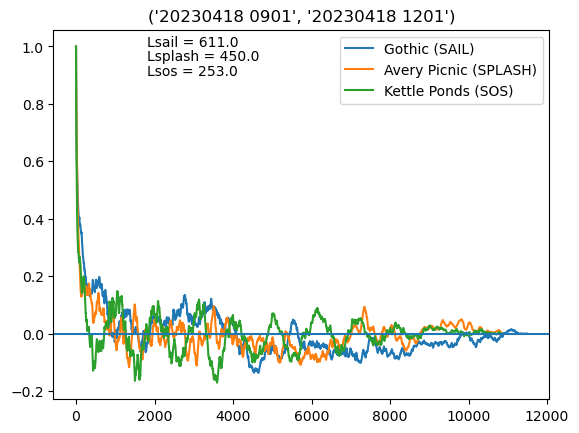

The first root is at lag (s): 166.0
The integration result_sail is: 32.65452640240175
The mean wind speed is: 3.9306933942806666
The integral length scale is: 128.35493122328418
The first root is at lag (s): 216.7
The integration result_splash is: 66.29596278012579
The mean wind speed is: 3.9357090809231203
The integral length scale is: 260.9216227422823
The first root is at lag (s): 709.0
The integration result_sos is: 73.73974982655673
The mean wind speed is: 4.075636863708496
The integral length scale is: 300.5364427137568


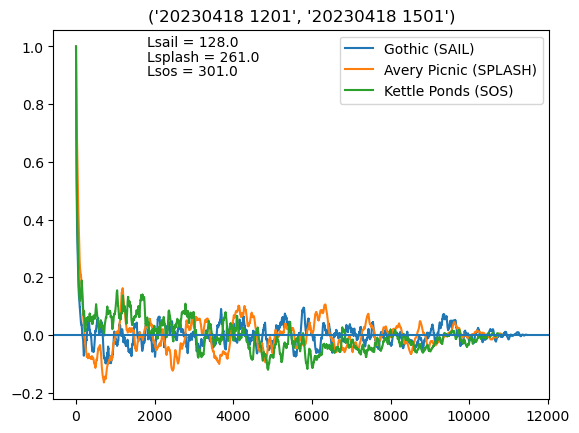

The first root is at lag (s): 1227.8
The integration result_sail is: 168.62448202559324
The mean wind speed is: 3.749790430816164
The integral length scale is: 632.3064691009017
The first root is at lag (s): 298.4
The integration result_splash is: 75.75019620133699
The mean wind speed is: 3.670821762891135
The integral length scale is: 278.0654687591412
The first root is at lag (s): 203.0
The integration result_sos is: 30.98922826396738
The mean wind speed is: 5.358426570892334
The integral length scale is: 166.0535041410905


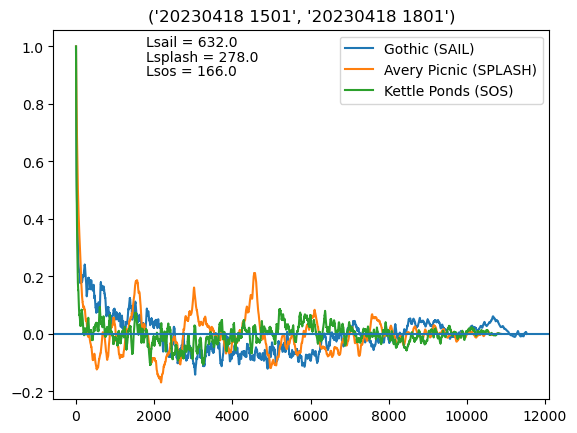

The first root is at lag (s): 1706.0
The integration result_sail is: 232.78612276112202
The mean wind speed is: 3.9939718999001936
The integral length scale is: 929.7412329946382
The first root is at lag (s): 1085.3
The integration result_splash is: 211.6842420151671
The mean wind speed is: 4.879002962684289
The integral length scale is: 1032.8080439455782
The first root is at lag (s): 272.7
The integration result_sos is: 47.843217521753104
The mean wind speed is: 4.9636149406433105
The integral length scale is: 237.47530929942153


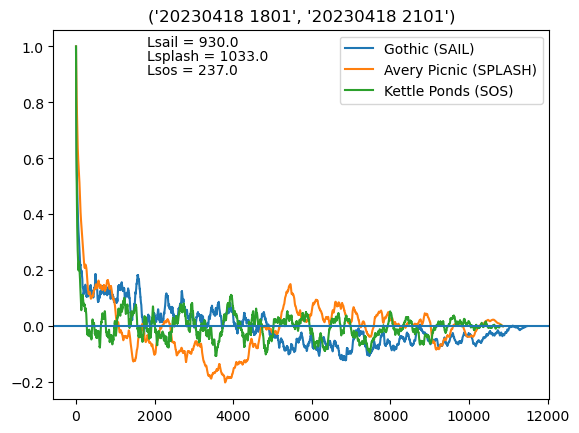

The first root is at lag (s): 1367.8
The integration result_sail is: 148.5592239390514
The mean wind speed is: 2.5322130473120477
The integral length scale is: 376.18360515701823
The first root is at lag (s): 989.6
The integration result_splash is: 267.6312637829651
The mean wind speed is: 3.7583338541346585
The integral length scale is: 1005.8476391003607
The first root is at lag (s): 1104.45
The integration result_sos is: 188.80945949411728
The mean wind speed is: 3.277867555618286
The integral length scale is: 618.892401469592


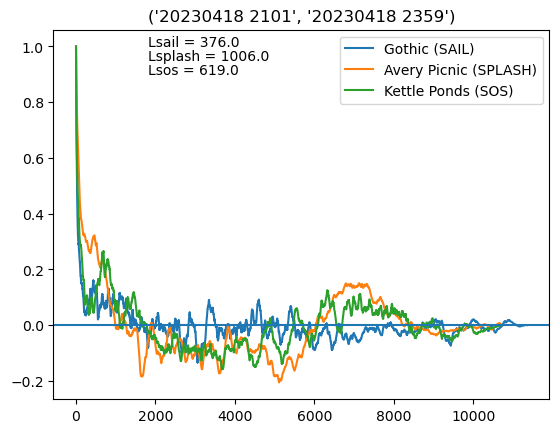

In [28]:
for time_period in [
    ('20230418 0000', '20230418 0301'),
    ('20230418 0301', '20230418 0601'),
    ('20230418 0601', '20230418 0901'),
    ('20230418 0901', '20230418 1201'),
    ('20230418 1201', '20230418 1501'),
    ('20230418 1501', '20230418 1801'),
    ('20230418 1801', '20230418 2101'),
    ('20230418 2101', '20230418 2359'),
]:
    # SAIL
    src_sail = fast_df_sail.loc[time_period[0]: time_period[1]]
    src_sail = src_sail.assign(
        spd = np.sqrt(src_sail['u']**2 + src_sail['v']**2)
    )
    spd_corr_result_sail = np.correlate(
        src_sail['spd'] - src_sail['spd'].mean(), 
        src_sail['spd'] - src_sail['spd'].mean(), 
        mode='full'
    )
    result_sail = spd_corr_result_sail[spd_corr_result_sail.size // 2:]
    result_sail = pd.DataFrame({"R": result_sail / float(result_sail.max())})
    result_sail['lag (s)'] = result_sail.index/10

    first_root_sail = find_root(result_sail, 'R',  'lag (s)')
    integral_result_sail = np.trapz(
        result_sail['R'].loc[:first_root_sail],
        result_sail['lag (s)'].loc[:first_root_sail],
    )
    integral_length_scale_sail = (integral_result_sail * src_sail['spd'].mean())
    print(f'The integration result_sail is: {integral_result_sail}')
    print(f'The mean wind speed is: {src_sail['spd'].mean()}')
    print(f"The integral length scale is: {integral_length_scale_sail}")


    # SPLASH
    src_splash = fast_df_splash.loc[time_period[0]: time_period[1]]
    src_splash = src_splash.assign(
        spd = np.sqrt(src_splash['u']**2 + src_splash['v']**2)
    )
    spd_corr_result_splash = np.correlate(
        src_splash['spd'] - src_splash['spd'].mean(), 
        src_splash['spd'] - src_splash['spd'].mean(), 
        mode='full'
    )
    result_splash = spd_corr_result_splash[spd_corr_result_splash.size // 2:]
    result_splash = pd.DataFrame({"R": result_splash / float(result_splash.max())})
    result_splash['lag (s)'] = result_splash.index/10

    first_root_splash = find_root(result_splash, 'R',  'lag (s)')
    integral_result_splash = np.trapz(
        result_splash['R'].loc[:first_root_splash],
        result_splash['lag (s)'].loc[:first_root_splash],
    )
    integral_length_scale_splash = (integral_result_splash * src_splash['spd'].mean())
    print(f'The integration result_splash is: {integral_result_splash}')
    print(f'The mean wind speed is: {src_splash['spd'].mean()}')
    print(f"The integral length scale is: {integral_length_scale_splash}")


    # SOS
    src_sos = fast_df_sos.loc[time_period[0]: time_period[1]]
    src_sos = src_sos.assign(
        spd = np.sqrt(src_sos['u']**2 + src_sos['v']**2)
    )
    spd_corr_result_sos = np.correlate(
        src_sos['spd'] - src_sos['spd'].mean(), 
        src_sos['spd'] - src_sos['spd'].mean(), 
        mode='full'
    )
    result_sos = spd_corr_result_sos[spd_corr_result_sos.size // 2:]
    result_sos = pd.DataFrame({"R": result_sos / float(result_sos.max())})
    result_sos['lag (s)'] = result_sos.index/20

    first_root_sos = find_root(result_sos, 'R',  'lag (s)')
    integral_result_sos = np.trapz(
        result_sos['R'].loc[:first_root_sos],
        result_sos['lag (s)'].loc[:first_root_sos],
    )
    integral_length_scale_sos = integral_result_sos * src_sos['spd'].mean()
    print(f'The integration result_sos is: {integral_result_sos}')
    print(f'The mean wind speed is: {src_sos['spd'].mean()}')
    print(f"The integral length scale is: {integral_length_scale_sos}")

    plt.plot(result_sail['lag (s)'], result_sail["R"], label='Gothic (SAIL)')
    plt.plot(result_splash['lag (s)'], result_splash["R"], label='Avery Picnic (SPLASH)')
    plt.plot(result_sos['lag (s)'], result_sos["R"], label='Kettle Ponds (SOS)')
    plt.text(x=1800, y=1, s = f"Lsail = {round(integral_length_scale_sail,0)}")
    plt.text(x=1800, y=0.95, s = f"Lsplash = {round(integral_length_scale_splash,0)}")
    plt.text(x=1800, y=0.9, s = f"Lsos = {round(integral_length_scale_sos,0)}")
    plt.title(time_period)
    plt.axhline(0)
    plt.legend()
    plt.show()

## For entire day, using moving window averages

In [324]:
src_sail_wholeday = fast_df_sail.assign(
    spd = np.sqrt(fast_df_sail['u']**2 + fast_df_sail['v']**2)
)
src_sail_wholeday['spd_fluc'] = src_sail_wholeday['spd'] - src_sail_wholeday['spd'].rolling(window='30min').mean()
spd_corr_result_sail_wholeday = np.correlate(
    src_sail_wholeday['spd_fluc'],
    src_sail_wholeday['spd_fluc'],
    mode='full'
)


In [325]:
src_splash_wholeday = fast_df_splash.assign(
    spd = np.sqrt(fast_df_splash['u']**2 + fast_df_splash['v']**2)
)
src_splash_wholeday['spd_fluc'] = src_splash_wholeday['spd'] - src_splash_wholeday['spd'].rolling(window='30min').mean()
spd_corr_result_splash_wholeday = np.correlate(
    src_splash_wholeday['spd_fluc'],
    src_splash_wholeday['spd_fluc'],
    mode='full'
)


In [326]:
src_sos_wholeday = fast_df_sos.assign(
    spd = np.sqrt(fast_df_sos['u']**2 + fast_df_sos['v']**2)
)
src_sos_wholeday['spd_fluc'] = src_sos_wholeday['spd'] - src_sos_wholeday['spd'].rolling(window='30min').mean()
spd_corr_result_sos_wholeday = np.correlate(
    src_sos_wholeday['spd_fluc'],
    src_sos_wholeday['spd_fluc'],
    mode='full'
)


In [327]:
result_sail = spd_corr_result_sail_wholeday[spd_corr_result_sail_wholeday.size // 2:]
result_sail = pd.DataFrame({"R": result_sail / float(result_sail.max())})
result_sail['lag_s'] = result_sail.index/10
first_root_sail = find_root(result_sail, 'R',  'lag_s')
integral_result_sail = np.trapz(
    result_sail['R'].loc[:first_root_sail],
    result_sail['lag_s'].loc[:first_root_sail],
)
integral_length_scale_sail = (integral_result_sail * src_sail['spd'].mean())


result_splash = spd_corr_result_splash_wholeday[spd_corr_result_splash_wholeday.size // 2:]
result_splash = pd.DataFrame({"R": result_splash / float(result_splash.max())})
result_splash['lag_s'] = result_splash.index/10
first_root_splash = find_root(result_splash, 'R',  'lag_s')
integral_result_splash = np.trapz(
    result_splash['R'].loc[:first_root_splash],
    result_splash['lag_s'].loc[:first_root_splash],
)
integral_length_scale_splash = (integral_result_splash * src_splash['spd'].mean())


result_sos = spd_corr_result_sos_wholeday[spd_corr_result_sos_wholeday.size // 2:]
result_sos = pd.DataFrame({"R": result_sos / float(result_sos.max())})
result_sos['lag_s'] = result_sos.index/20
first_root_sos = find_root(result_sos, 'R',  'lag_s')
integral_result_sos = np.trapz(
    result_sos['R'].loc[:first_root_sos],
    result_sos['lag_s'].loc[:first_root_sos],
)
integral_length_scale_sos = (integral_result_sos * src_sos['spd'].mean())

The first root is at lag (s): 1003.5
The first root is at lag (s): 1239.5
The first root is at lag (s): 1108.5


In [328]:
alt.Chart(result_sail.query("lag_s < 5000")).transform_filter(
    alt.datum.lag_s > 0
).mark_line().encode(
    alt.X('lag_s:Q').scale(type='log'),
    alt.Y('R:Q')
).properties(title=f'L = {round(integral_length_scale_sail, 1)}') | alt.Chart(result_splash.query("lag_s < 5000")).transform_filter(
    alt.datum.lag_s > 0
).mark_line().encode(
    alt.X('lag_s:Q').scale(type='log'),
    alt.Y('R:Q')
).properties(title=f'L = {round(integral_length_scale_splash, 1)}') | alt.Chart(result_sos.query("lag_s < 5000")).transform_filter(
    alt.datum.lag_s > 0
).mark_line().encode(
    alt.X('lag_s:Q').scale(type='log'),
    alt.Y('R:Q')
).properties(title=f'L = {round(integral_length_scale_sos, 1)}')

alt.HConcatChart(...)